In [1]:
import numpy as np
import pandas as pd

from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler

from monitor_models import *
from monitor import Monitor


%matplotlib inline

#### Generate data from scratch

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

N_IN_PART = 10000
N_FEATURES = 4

X1, y1 = make_classification(n_samples=N_IN_PART, n_features=N_FEATURES, n_informative=N_FEATURES, n_redundant=0, n_repeated=0, 
                             n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.0, class_sep=1.0, 
                             hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=1)
X1 = pd.DataFrame(X1)
X1['part'] = [1 for _ in range(N_IN_PART)]

X2, y2 = make_classification(n_samples=N_IN_PART, n_features=N_FEATURES, n_informative=N_FEATURES, n_redundant=0, n_repeated=0, 
                             n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.0, class_sep=1.0, 
                             hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=1)
X2 = pd.DataFrame(X2)
X2['part'] = [2 for _ in range(N_IN_PART)]

X3, y3 = make_classification(n_samples=N_IN_PART, n_features=N_FEATURES, n_informative=N_FEATURES, n_redundant=0, n_repeated=0, 
                             n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.0, class_sep=1.0, 
                             hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=1)
X3 = pd.DataFrame(X3)
X3['part'] = [3 for _ in range(N_IN_PART)]

lr = LogisticRegression(random_state=1)
lr.fit(X1, y1)
preds1 = lr.predict_proba(X1)[:,1]
preds2 = lr.predict_proba(X2)[:,1]
preds3 = lr.predict_proba(X3)[:,1]

X_all = pd.concat([X1,X2,X3])
RS_all = np.concatenate([preds1,preds2,preds3])
X_all['score'] = RS_all
X_all.to_csv('test_data_mon.csv', index=False)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Set up an experiment

In [3]:
def run_experiment(path_to_data, batch_size, cumsize, stattest, rmodel):
    '''
    rmodel: 
      type of model for reconstruction loss
    '''
    
    data = pd.read_csv(path_to_data)
    features, risk_scores = data.drop(['score', 'part'], axis=1), data['score']
    
    # Feature scaling to prevent shift problems
    scaler = StandardScaler()
    features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    features['part'] = data['part']
        
    # Adapt training data to PyTorch model
    # Training data: FIRST part of dataset
    if 'forward' in dir(rmodel):
        training_data = np.matrix(features[features['part'].isin([0])]).astype('float32')
    else:
        training_data = features[features['part'].isin([0])]
    
    # Fit the model on the FIRST part of dataset
    rmodel.learn(training_data)
    
    # 
    monitor = Monitor(features, risk_scores, batch_size, cumsize, rmodel, stattest)
    monitor.simulation()
    monitor.plot(type='loss')
    monitor.plot(type='stat')
    monitor.plot(type='pval')
    return monitor

#### Get generated data from external sources

In [4]:
from os import listdir
import re
from os.path import isfile, join
mypath = 'data/'
paths_to_data = sorted([('data/'+f, int(re.findall('x(\d+)\.csv', f)[0])) for f in listdir(mypath) if isfile(join(mypath, f))],
                       key=lambda x: x[1])

N_DATASETS = 1

#### Elliptic Envelope

C:\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:646: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4861: RuntimeWarning: invalid value encountered in true_divide
  cdf1 = np.searchsorted(data1, data_all, side='right') / n1
C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4867: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: inva

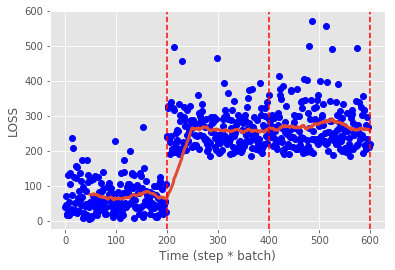

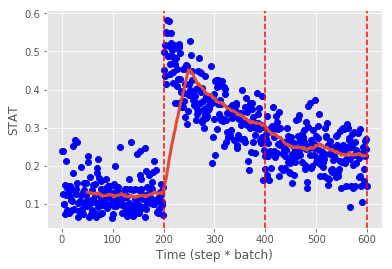

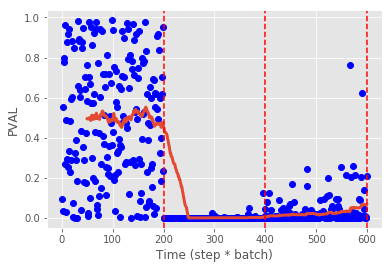

******************************


In [5]:
rmodel = EllipticEnvelopeExtended(contamination=0.0, random_state=1)

monitors = []
for path_to_data, nfeatures in paths_to_data[:N_DATASETS]:
    monitor = run_experiment(path_to_data=path_to_data, batch_size=50, 
                             cumsize=5, stattest=ks_2samp, rmodel=rmodel)
    monitors.append(monitor)
    print('*'*30)

#### Simple Autoencoder

Epoch: 20 train loss: 0.14959
Epoch: 40 train loss: 0.12432
Epoch: 60 train loss: 0.12206
Epoch: 80 train loss: 0.12165
Epoch: 100 train loss: 0.12129


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4861: RuntimeWarning: invalid value encountered in true_divide
  cdf1 = np.searchsorted(data1, data_all, side='right') / n1
C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4867: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


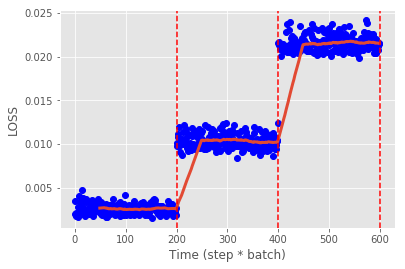

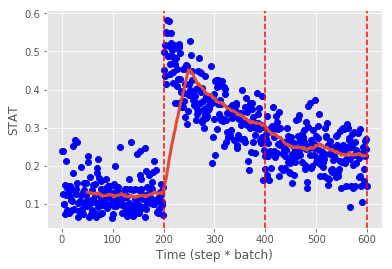

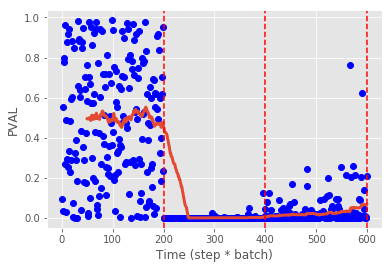

******************************


In [6]:
rmodel = DenseAE()

monitors = []
for path_to_data, nfeatures in paths_to_data[:N_DATASETS]:
    monitor = run_experiment(path_to_data=path_to_data, batch_size=50, 
                             cumsize=5, stattest=ks_2samp, rmodel=rmodel)
    monitors.append(monitor)
    print('*'*30)

#### One-Class SVM

C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4861: RuntimeWarning: invalid value encountered in true_divide
  cdf1 = np.searchsorted(data1, data_all, side='right') / n1
C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4867: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-

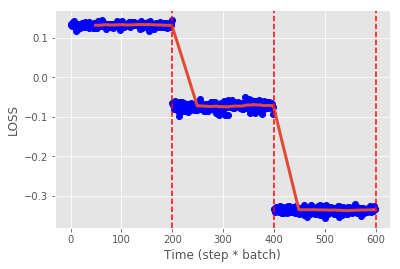

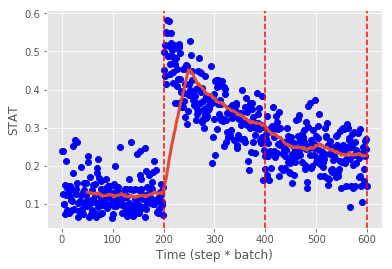

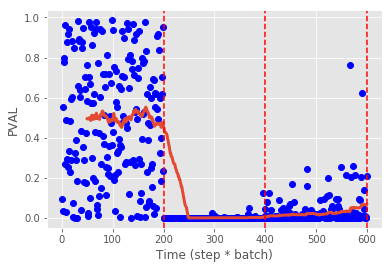

******************************


In [7]:
rmodel = OneClassSVMExtended(nu=0.001)

monitors = []
for path_to_data, nfeatures in paths_to_data[:N_DATASETS]:
    monitor = run_experiment(path_to_data=path_to_data, batch_size=50, 
                             cumsize=5, stattest=ks_2samp, rmodel=rmodel)
    monitors.append(monitor)
    print('*'*30)

#### Local Outlier Factor

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4861: RuntimeWarning: invalid value encountered in true_divide
  cdf1 = np.searchsorted(data1, data_all, side='right') / n1
C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4867: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


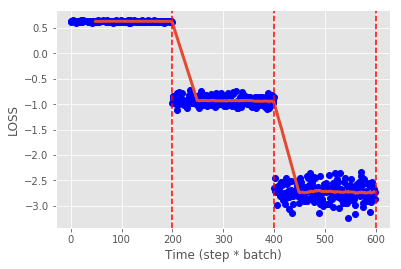

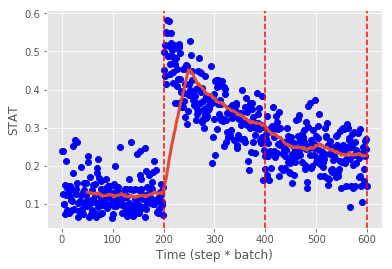

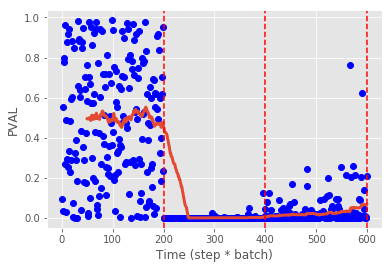

******************************


In [8]:
rmodel = LocalOutlierFactorExtended(contamination=0.001, novelty=True)

monitors = []
for path_to_data, nfeatures in paths_to_data[:N_DATASETS]:
    monitor = run_experiment(path_to_data=path_to_data, batch_size=50, 
                             cumsize=5, stattest=ks_2samp, rmodel=rmodel)
    monitors.append(monitor)
    print('*'*30)